In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import random, jit

from tqdm.auto import tqdm
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel, build_sghmc_kernel

import tensorflow_datasets as tfds

from flax import linen as nn

# Flax CNN

In [2]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x


In [3]:
cnn = CNN()

def loglikelihood(params, x, y):
    x = x[jnp.newaxis] # add an axis so that it works for a single data point
    logits = cnn.apply({'params':(params)}, x)
    label = jax.nn.one_hot(y, num_classes=10)
    return jnp.sum(logits*label) 

def logprior(params):
    return 1.

@jit
def accuracy_cnn(params, X, y):
    target_class = y
    predicted_class = jnp.argmax(cnn.apply({'params':(params)}, X), axis=1)
    return jnp.mean(predicted_class == target_class)


def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    return train_ds, test_ds


train_ds, test_ds = get_datasets()

X_train_s = train_ds['image']
y_train_s = jnp.array(train_ds['label'])
X_test_s = test_ds['image']
y_test_s = jnp.array(test_ds['label'])


data = (X_train_s, y_train_s)
batch_size = int(0.01*data[0].shape[0])

In [9]:
def run_sgmcmc(key, Nsamples, init_fn, my_kernel, get_params, accuracy_rate=100):
    "Run SGMCMC sampler and return the test accuracy list"
    accuracy_list = []
    params = cnn.init(key, jnp.ones([1,28,28,1]))['params']
    key, subkey = random.split(key)
    state = init_fn(subkey, params)

    for i in tqdm(range(Nsamples)):
        key, subkey = random.split(key)
        state = my_kernel(i, subkey, state)
        if i%accuracy_rate==0:
            accuracy_list.append(accuracy_cnn(get_params(state), X_test_s, y_test_s))
            
    return accuracy_list

### SGLD

In [10]:
%%time

init_fn, sgld_kernel, get_params = build_sgld_kernel(5e-6, loglikelihood, logprior, data, batch_size)

sgld_kernel = jit(sgld_kernel)

Nsamples = 2000
accuracy_list_sgld = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, sgld_kernel, get_params)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 28min 9s, sys: 7min 11s, total: 35min 21s
Wall time: 8min 48s


### SGHMC

In [ ]:
%%time

init_fn, sghmc_kernel, get_params = build_sghmc_kernel(1e-6, 4, loglikelihood, 
                                                       logprior, data, batch_size, compiled_leapfrog=False)

Nsamples = 500
accuracy_list_sghmc = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, 
                                 sghmc_kernel, get_params, accuracy_rate=25)

  0%|          | 0/500 [00:00<?, ?it/s]

### pSGLD

In [ ]:
%%time

init_fn, psgld_kernel, get_params = build_psgld_kernel(1e-3, loglikelihood, logprior, data, batch_size)

psgld_kernel = jit(psgld_kernel)

Nsamples = 2000
accuracy_list_psgld = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, psgld_kernel, get_params)

### sgldAdam

In [ ]:
%%time

init_fn, sgldAdam_kernel, get_params = build_sgldAdam_kernel(1e-2, loglikelihood, logprior, data, batch_size)

sgldAdam_kernel = jit(sgldAdam_kernel)

Nsamples = 2000
accuracy_list_sgldAdam = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, sgldAdam_kernel, get_params)

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(jnp.arange(0,2000,100), accuracy_list_sgld, label="SGLD", marker="+") # 5e-6
plt.plot(jnp.arange(0,500,25), accuracy_list_sghmc, label="SGHMC", marker="+") # dt=1e-6, L=4
plt.plot(jnp.arange(0,2000,100), accuracy_list_psgld, label="pSGLD", marker=">") # 1e-3
plt.plot(jnp.arange(0,2000,100), accuracy_list_sgldAdam, label="sgldAdam", marker="o") # 1e-2

plt.legend(fontsize=16)
plt.title("Test accuracy of SGMCMC samplers on MNIST with a CNN")
plt.xlabel("Iterations", size=20)
plt.ylabel("Test accuracy", size=20)

print(f"sgld: {100*accuracy_list_sgld[-1]:.1f}%")
print(f"sghmc: {100*accuracy_list_sghmc[-1]:.1f}%")
print(f"psgld: {100*accuracy_list_psgld[-1]:.1f}%")
print(f"sgldAdam: {100*accuracy_list_sgldAdam[-1]:.1f}%")


sgld: 98.1%
sghmc: 97.5%
psgld: 96.9%
sgldAdam: 92.5%


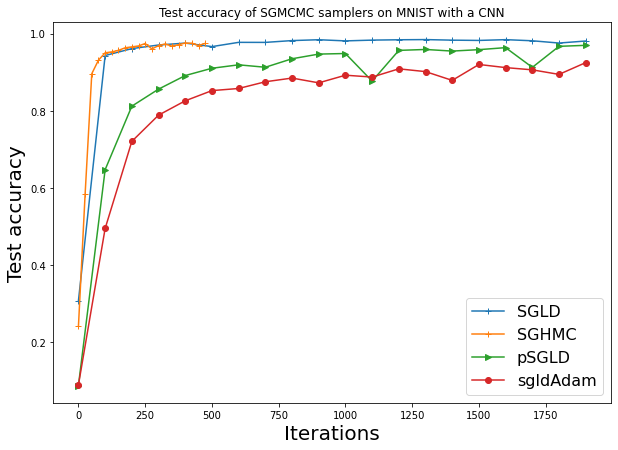

In [32]:
plt.figure(figsize=(10,7))

plt.plot(jnp.arange(0,2000,100), accuracy_list_sgld, label="SGLD", marker="+") # 5e-6
plt.plot(jnp.arange(0,500,25), accuracy_list_sghmc, label="SGHMC", marker="+") # dt=1e-6, L=4
plt.plot(jnp.arange(0,2000,100), accuracy_list_psgld, label="pSGLD", marker=">") # 1e-3
plt.plot(jnp.arange(0,2000,100), accuracy_list_sgldAdam, label="sgldAdam", marker="o") # 1e-2

plt.legend(fontsize=16)
plt.title("Test accuracy of SGMCMC samplers on MNIST with a CNN")
plt.xlabel("Iterations", size=20)
plt.ylabel("Test accuracy", size=20)

print(f"sgld: {100*accuracy_list_sgld[-1]:.1f}%")
print(f"sghmc: {100*accuracy_list_sghmc[-1]:.1f}%")
print(f"psgld: {100*accuracy_list_psgld[-1]:.1f}%")
print(f"sgldAdam: {100*accuracy_list_sgldAdam[-1]:.1f}%")
